<a href="https://colab.research.google.com/github/beckii0930/LLM/blob/main/esm2_binding_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
# files.upload()  # Upload kaggle.json
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!ls drive/MyDrive/Colab\ Notebooks/subset_binding_data.csv

'drive/MyDrive/Colab Notebooks/subset_binding_data.csv'


In [18]:
import pandas as pd

# Load full dataset
df = pd.read_csv("drive/MyDrive/Colab Notebooks/subset_binding_data.csv")


In [19]:
df.head()# df_filtered = df.dropna(subset=["aa_seq", "ddG_ML"])

# # Step 3: Rename and extract relevant columns
# df_model_input = df_filtered[["aa_seq", "ddG_ML"]].copy()
# df_model_input = df_model_input.rename(columns={
#     "aa_seq": "sequence",
#     "ddG_ML": "ddg"
# })


,aa_seq,ddG_ML,Stabilizing_mut,ddg
0,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,0.017198,False,0.017198
1,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,0.084903,False,0.084903
2,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,0.000854,False,0.000854
3,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,-0.041995,False,-0.041995
4,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,-0.744686,False,-0.744686


In [20]:
!pip install fair-esm


In [25]:
import torch, esm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
pretrained_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
#esm2_t33_650M_UR50D too big

# tokenizer
def seq_to_embedding(sequence):
  inputs = tokenizer(sequence, return_tensors='pt', padding = True,
                     truncation = True)
  with torch.no_grad():
    outputs = pretrained_model(**inputs)

  embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
  return embedding

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random

class Binding_Dataset(Dataset):
  def __init__(self, csv_file, max_len=1022, n_clusters=500):
      self.df = pd.read_csv(csv_file)
      print(self.df.head)
      self.df["Stabilizing_mut"] = self.df["Stabilizing_mut"].map({"True": 1,
                                                                "False": 0})
      print(self.df["Stabilizing_mut"].unique())
      self.df = self.df[self.df["Stabilizing_mut"].notna()]

      # Convert Stabilizing_mut (True = stabilizing) to label
      # (0 = stabilizing, 1 = destabilizing)
      # self.df["label"] = (~self.df["Stabilizing_mut"]).astype(int)
      print(self.df)
      df_stable = self.df[self.df["Stabilizing_mut"] == 1].copy()  # minority class (keep all)
      df_destab = self.df[self.df["Stabilizing_mut"] == 0].copy()  # majority class
      print(f"Before sampling: {len(df_stable)} stabilizing, {len(df_destab)} destabilizing")
      # Convert destabilizing to embeddings
      # destab_embeddings = [
      #     seq_to_embedding(seq) for seq in tqdm(df_destab["aa_seq"],
      #                                           desc="Embedding Destabilizing")
      # ]
      # kmeans to get representative majority for majority class
      # n_clusters = len(df_stable)
      # X = np.stack(destab_embeddings)
      # kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
      # chosen_idxs = []

      # for i in range(n_clusters):
      #     members = np.where(kmeans.labels_ == i)[0]
      #     centroid = kmeans.cluster_centers_[i]
      #     dists = np.linalg.norm(X[members] - centroid, axis=1)
      #     chosen_idx = members[np.argmin(dists)]
      #     chosen_idxs.append(chosen_idx)

      # df_destab_sampled = df_destab.iloc[chosen_idxs].copy()
      # df_destab_sampled["embedding"] = X[chosen_idxs].tolist()

      ###### reservoir sampling
      random.seed(42)
      reservoir_size = len(df_stable)
      reservoir = []
      for i, row in enumerate(df_destab.itertuples(index=False)):
          if i < reservoir_size:
              reservoir.append(row)
          else:
              j = random.randint(0, i)
              if j < reservoir_size:
                  reservoir[j] = row
      df_destab_sampled = pd.DataFrame(reservoir, columns=df_destab.columns)
      self.df = pd.concat([df_stable, df_destab_sampled]).reset_index(drop=True)
      print(f"After sampling: {len(df_stable)} stabilizing, {len(df_destab_sampled)} destabilizing")

      self.sequences = self.df["aa_seq"].tolist()
      self.labels = self.df["Stabilizing_mut"].values
      self.max_len = max_len

      # Convert sequences to embeddings
      self.embeddings = [seq_to_embedding(seq) for seq in tqdm(self.sequences, desc="Embedding Sequences")]


  def __len__(self):
    return len(self.embeddings)

  def __getitem__(self, idx):
    embedding = self.embeddings[idx]
    label = self.labels[idx]

    label_tensor = torch.tensor(label, dtype=torch.float32)
    return embedding, label_tensor

In [54]:
binding_dataset = Binding_Dataset("drive/MyDrive/Colab Notebooks/subset_binding_data.csv")

from torch.utils.data import random_split
train_size = int(0.8 * len(binding_dataset))
test_size = len(binding_dataset) - train_size

train_dataset, test_dataset = random_split(binding_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

<bound method NDFrame.head of                                                  aa_seq    ddG_ML  \
0       DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER  0.017198   
1       DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER  0.084903   
2       DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER  0.000854   
3       DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER -0.041995   
4       DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER -0.744686   
...                                                 ...       ...   
607834      ADDEVAKLLVDAYRKNDEDKLEEVPKRYNISIEQVKRLIRKVL -1.686936   
607835      ADDEVAKLLVDAYRKNDEDKLEEVPKRYNISWEQVKRLIRKVL -2.047592   
607836      ADDEVAKLLVDAYRKNDEDKLEEVPKRYNISYEQVKRLIRKVL -2.125779   
607837      ADDEVAKLLVDAYRKNDEDKLEEVPKRYNISFEQVKRLIRKVL -2.081993   
607838      ADDEVAKLLVDAYRKNDEDKLEEVPKRYNISPEQVKRLIRKVL -2.632159   

       Stabilizing_mut       ddg  
0                False  0.017198  
1                False  0.084903  
2                False  0.000854  
3

Embedding Sequences:   0%|          | 0/4778 [00:00<?, ?it/s]

In [60]:
tokenizer

EsmTokenizer(name_or_path='facebook/esm2_t6_8M_UR50D', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

AttributeError: 'Binding_Dataset' object has no attribute 'shape'

In [56]:
# import torch.nn as nn
# import torch.optim as optim
# model = nn.Sequential(
#     nn.Linear(320, 128),
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 1),
#     nn.Sigmoid()
# )
# model = nn.Linear(320, 1)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
model = nn.Sequential(
    nn.Linear(320, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

# BAD OPTIMIZER, MANUAL SGD

In [85]:
num_epochs = 50
for epoch in range(num_epochs):
  model.train()
  loss_list = []
  for embeddings, labels in train_loader:
    outputs = model(embeddings).squeeze()
    loss=nn.BCELoss()(outputs, labels)
    loss_list.append(loss.item())

    for p in model.parameters():
      p.grad=None
    loss.backward()
    for p in model.parameters():
      p.data -= 0.01 * p.grad
  tmp = sum(loss_list) / len(loss_list)
  print(f"Epoch [{epoch+1}/{num_epochs}], loss:{tmp:.4f}")

Epoch [1/50], loss:0.2486
Epoch [2/50], loss:0.2447
Epoch [3/50], loss:0.2487
Epoch [4/50], loss:0.2526
Epoch [5/50], loss:0.2562
Epoch [6/50], loss:0.2502
Epoch [7/50], loss:0.2565
Epoch [8/50], loss:0.2521
Epoch [9/50], loss:0.2498
Epoch [10/50], loss:0.2590
Epoch [11/50], loss:0.2580
Epoch [12/50], loss:0.2538
Epoch [13/50], loss:0.2453
Epoch [14/50], loss:0.2535
Epoch [15/50], loss:0.2503
Epoch [16/50], loss:0.2564
Epoch [17/50], loss:0.2375
Epoch [18/50], loss:0.2384
Epoch [19/50], loss:0.2497
Epoch [20/50], loss:0.2508
Epoch [21/50], loss:0.2396
Epoch [22/50], loss:0.2416
Epoch [23/50], loss:0.2356
Epoch [24/50], loss:0.2408
Epoch [25/50], loss:0.2526
Epoch [26/50], loss:0.2466
Epoch [27/50], loss:0.2399
Epoch [28/50], loss:0.2358
Epoch [29/50], loss:0.2422
Epoch [30/50], loss:0.2408
Epoch [31/50], loss:0.2357
Epoch [32/50], loss:0.2477
Epoch [33/50], loss:0.2443
Epoch [34/50], loss:0.2401
Epoch [35/50], loss:0.2415
Epoch [36/50], loss:0.2412
Epoch [37/50], loss:0.2325
Epoch [38/

# Adam with adjusted learning rate

In [64]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np

num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

lossi = []
val_losses = []
train_losses = []

# Binary Cross Entropy
criterion = torch.nn.BCELoss()  # if model has Sigmoid()
# Or use BCEWithLogitsLoss if you remove final Sigmoid in model

optimizer = optim.Adam(model.parameters(), lr=0.001)

running_loss = 0
best_val_loss = float("inf")
patience = 5
wait = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for embeddings, labels in tqdm(train_loader, desc="Batching", leave=True):
        embeddings, labels = embeddings.to(device), labels.to(device)

        outputs = model(embeddings).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item() * embeddings.size(0)
        lossi.append(loss.item())

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    # --- Validation ---
    model.eval()
    y_true = []
    y_pred = []
    val_loss = 0.0
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * embeddings.size(0)

            probs = outputs.detach().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    acc = accuracy_score(y_true, y_pred)
    print(f"Val Loss: {val_loss:.4f} | Accuracy: {acc:.3f}")

    # Early stopping on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/200], Train Loss: 0.6066
Val Loss: 0.5540 | Accuracy: 0.726


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/200], Train Loss: 0.5538
Val Loss: 0.5347 | Accuracy: 0.738


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/200], Train Loss: 0.5284
Val Loss: 0.5307 | Accuracy: 0.745


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/200], Train Loss: 0.5159
Val Loss: 0.5205 | Accuracy: 0.746


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/200], Train Loss: 0.5031
Val Loss: 0.5220 | Accuracy: 0.754


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/200], Train Loss: 0.4907
Val Loss: 0.5257 | Accuracy: 0.745


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/200], Train Loss: 0.4666
Val Loss: 0.4972 | Accuracy: 0.769


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/200], Train Loss: 0.4672
Val Loss: 0.4982 | Accuracy: 0.781


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/200], Train Loss: 0.4625
Val Loss: 0.4934 | Accuracy: 0.785


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/200], Train Loss: 0.4521
Val Loss: 0.4958 | Accuracy: 0.765


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/200], Train Loss: 0.4530
Val Loss: 0.4857 | Accuracy: 0.778


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/200], Train Loss: 0.4429
Val Loss: 0.4874 | Accuracy: 0.790


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/200], Train Loss: 0.4369
Val Loss: 0.4859 | Accuracy: 0.790


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/200], Train Loss: 0.4296
Val Loss: 0.4790 | Accuracy: 0.791


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/200], Train Loss: 0.4289
Val Loss: 0.4946 | Accuracy: 0.773


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/200], Train Loss: 0.4113
Val Loss: 0.4618 | Accuracy: 0.794


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/200], Train Loss: 0.4202
Val Loss: 0.4939 | Accuracy: 0.781


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/200], Train Loss: 0.4151
Val Loss: 0.4718 | Accuracy: 0.805


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/200], Train Loss: 0.4006
Val Loss: 0.4870 | Accuracy: 0.780


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/200], Train Loss: 0.3984
Val Loss: 0.4783 | Accuracy: 0.776


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/200], Train Loss: 0.3996
Val Loss: 0.4517 | Accuracy: 0.815


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/200], Train Loss: 0.3865
Val Loss: 0.4664 | Accuracy: 0.797


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/200], Train Loss: 0.3927
Val Loss: 0.5021 | Accuracy: 0.795


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/200], Train Loss: 0.3949
Val Loss: 0.4819 | Accuracy: 0.792


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/200], Train Loss: 0.3899
Val Loss: 0.4512 | Accuracy: 0.800


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/200], Train Loss: 0.3860
Val Loss: 0.4763 | Accuracy: 0.768


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/200], Train Loss: 0.3823
Val Loss: 0.4673 | Accuracy: 0.812


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/200], Train Loss: 0.3748
Val Loss: 0.4639 | Accuracy: 0.799


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/200], Train Loss: 0.3633
Val Loss: 0.4490 | Accuracy: 0.800


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/200], Train Loss: 0.3642
Val Loss: 0.4589 | Accuracy: 0.820


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/200], Train Loss: 0.3666
Val Loss: 0.4529 | Accuracy: 0.814


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/200], Train Loss: 0.3746
Val Loss: 0.4748 | Accuracy: 0.799


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/200], Train Loss: 0.3674
Val Loss: 0.4640 | Accuracy: 0.795


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/200], Train Loss: 0.3538
Val Loss: 0.4555 | Accuracy: 0.811


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/200], Train Loss: 0.3562
Val Loss: 0.4700 | Accuracy: 0.772


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/200], Train Loss: 0.3572
Val Loss: 0.4320 | Accuracy: 0.810


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/200], Train Loss: 0.3511
Val Loss: 0.4453 | Accuracy: 0.809


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/200], Train Loss: 0.3498
Val Loss: 0.4396 | Accuracy: 0.814


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/200], Train Loss: 0.3516
Val Loss: 0.4615 | Accuracy: 0.818


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/200], Train Loss: 0.3444
Val Loss: 0.4417 | Accuracy: 0.818


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/200], Train Loss: 0.3402
Val Loss: 0.4574 | Accuracy: 0.800


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/200], Train Loss: 0.3442
Val Loss: 0.4264 | Accuracy: 0.827


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/200], Train Loss: 0.3423
Val Loss: 0.4411 | Accuracy: 0.821


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/200], Train Loss: 0.3252
Val Loss: 0.4458 | Accuracy: 0.824


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/200], Train Loss: 0.3165
Val Loss: 0.4486 | Accuracy: 0.825


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/200], Train Loss: 0.3377
Val Loss: 0.4311 | Accuracy: 0.818


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/200], Train Loss: 0.3327
Val Loss: 0.4512 | Accuracy: 0.814


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/200], Train Loss: 0.3412
Val Loss: 0.4499 | Accuracy: 0.817


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/200], Train Loss: 0.3287
Val Loss: 0.4600 | Accuracy: 0.789


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/200], Train Loss: 0.3191
Val Loss: 0.4413 | Accuracy: 0.824


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/200], Train Loss: 0.3144
Val Loss: 0.4231 | Accuracy: 0.834


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/200], Train Loss: 0.3255
Val Loss: 0.4467 | Accuracy: 0.819


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/200], Train Loss: 0.3170
Val Loss: 0.4463 | Accuracy: 0.823


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/200], Train Loss: 0.3207
Val Loss: 0.4473 | Accuracy: 0.832


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/200], Train Loss: 0.3161
Val Loss: 0.4424 | Accuracy: 0.820


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/200], Train Loss: 0.3202
Val Loss: 0.4464 | Accuracy: 0.815


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/200], Train Loss: 0.3141
Val Loss: 0.4404 | Accuracy: 0.823


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/200], Train Loss: 0.3029
Val Loss: 0.4396 | Accuracy: 0.824


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/200], Train Loss: 0.2998
Val Loss: 0.4519 | Accuracy: 0.819


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/200], Train Loss: 0.3071
Val Loss: 0.4455 | Accuracy: 0.817


Batching:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/200], Train Loss: 0.3152
Val Loss: 0.4365 | Accuracy: 0.825
Early stopping at epoch 61


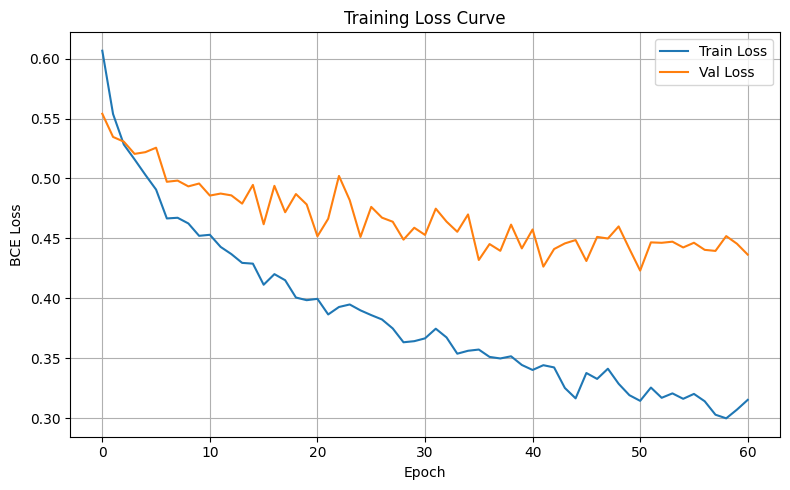

In [86]:
import matplotlib.pyplot as plt
# plt.plot(torch.tensor(lossi).view(-1, 20).mean(1))
plt.figure(figsize=(8, 5))
# plt.plot(range(1, num_epochs + 1), lossi, marker='o', label='Train Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')

plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

=== Final Test Metrics ===
Accuracy:  0.8253
Precision: 0.7988
Recall:    0.8587
F1 Score:  0.8277
ROC AUC:   0.8927
Confusion Matrix:
[[388 101]
 [ 66 401]]


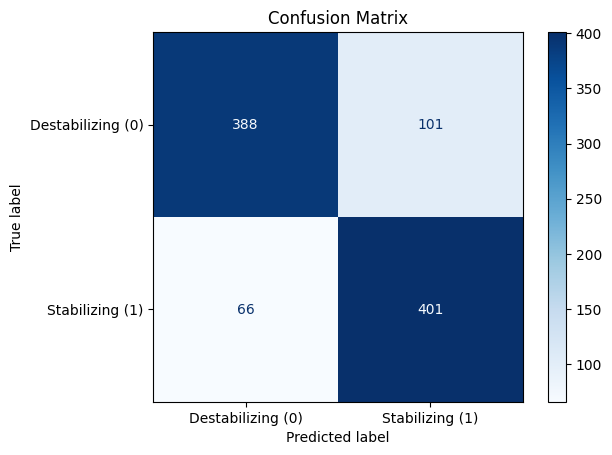

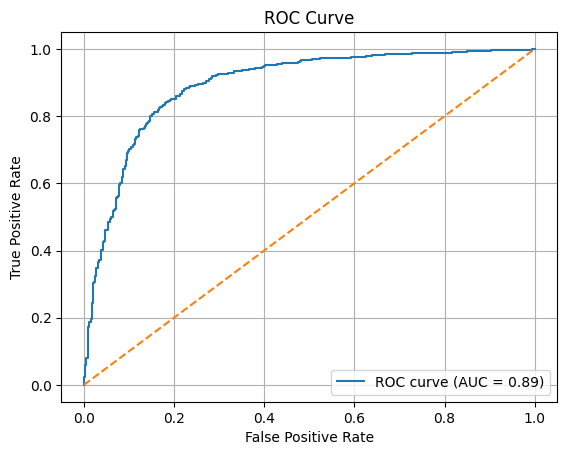

In [67]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    roc_curve
)
import matplotlib.pyplot as plt

# Load best model if early stopping occurred
model.load_state_dict(best_model_state)
model.eval()

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings).squeeze()
        probs = outputs.cpu().numpy()
        preds = (probs > 0.5).astype(int)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
cm = confusion_matrix(y_true, y_pred)

print("=== Final Test Metrics ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Destabilizing (0)", "Stabilizing (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [76]:
# First ensure model is in eval mode
model.eval()
y_all = []

with torch.no_grad():
    for loader in [train_loader, test_loader]:
        for embeddings, _ in loader:
            embeddings = embeddings.to(device)
            outputs = model(embeddings).squeeze()
            probs = torch.sigmoid(outputs)
            y_all.extend(probs.cpu().numpy())

y_all = np.array(y_all)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


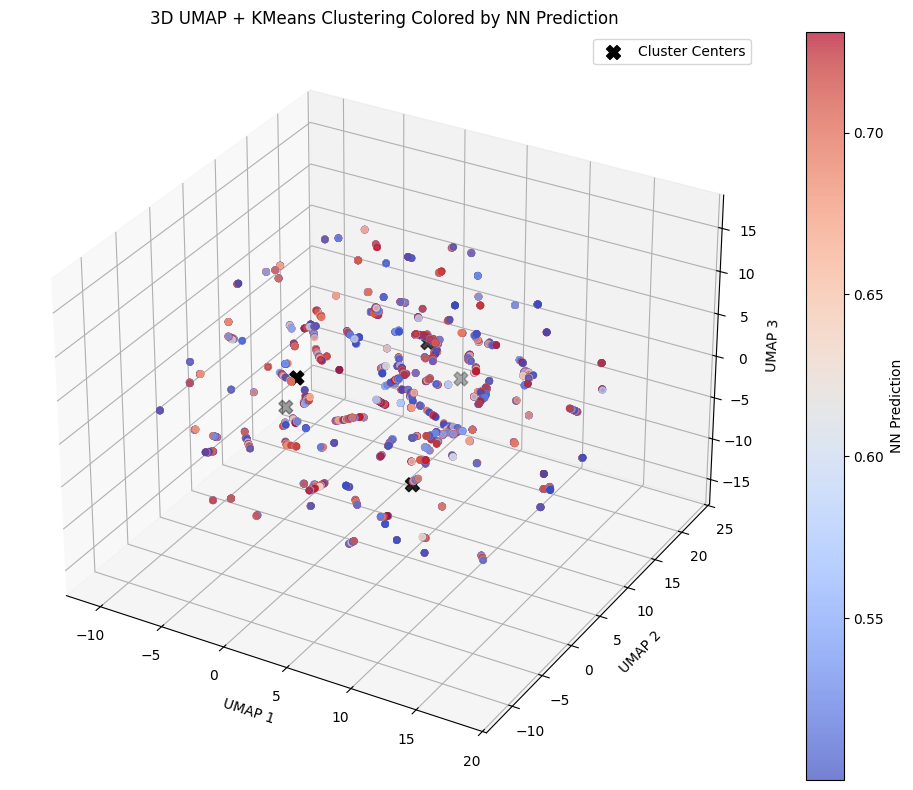

In [80]:
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Step 1: 3D UMAP dimensionality reduction
reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap_3D = reducer.fit_transform(X_all)  # X_all = np.vstack([X_train, X_test])

# Step 2: KMeans clustering in 3D space
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_umap_3D)
centers_3D = kmeans.cluster_centers_

# Step 3: 3D plot colored by NN prediction
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap_3D[:, 0], X_umap_3D[:, 1], X_umap_3D[:, 2],
                     c=y_all, cmap='coolwarm', alpha=0.7)

ax.scatter(centers_3D[:, 0], centers_3D[:, 1], centers_3D[:, 2],
           c='black', marker='X', s=100, label='Cluster Centers')

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.set_title("3D UMAP + KMeans Clustering Colored by NN Prediction")
fig.colorbar(scatter, ax=ax, label="NN Prediction")

plt.legend()
plt.tight_layout()
plt.show()


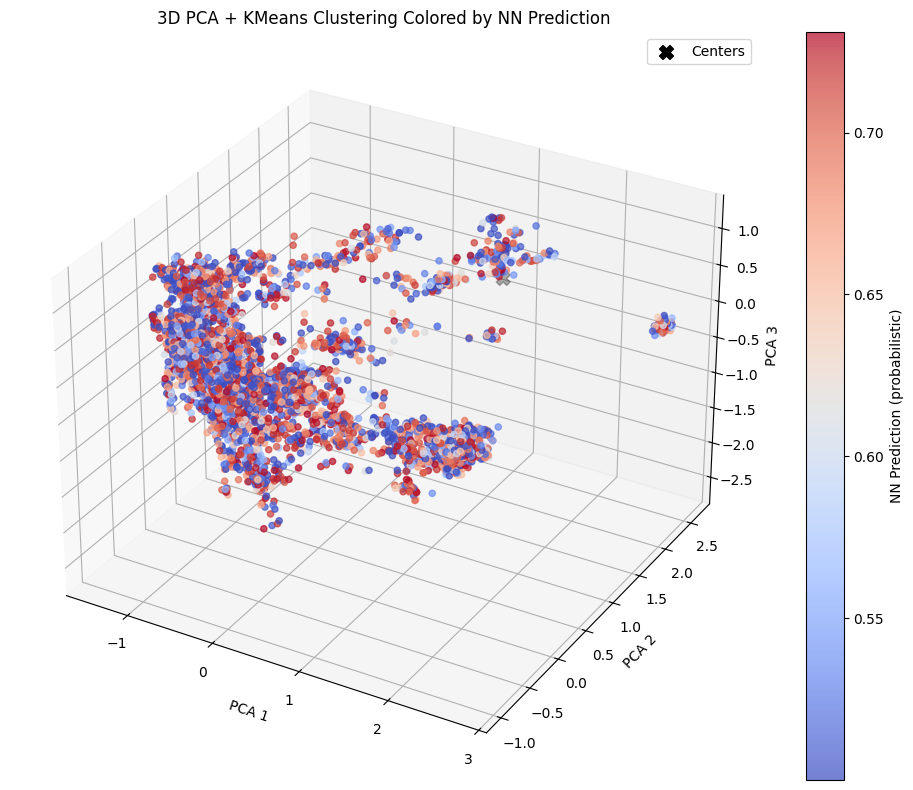

In [79]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 3D PCA
pca = PCA(n_components=3)
X_pca_3D = pca.fit_transform(X_all)

# KMeans on 3D PCA data
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca_3D)
centers_3D = kmeans.cluster_centers_

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3D[:, 0], X_pca_3D[:, 1], X_pca_3D[:, 2],
                     c=y_all, cmap='coolwarm', alpha=0.7)

ax.scatter(centers_3D[:, 0], centers_3D[:, 1], centers_3D[:, 2],
           c='black', marker='X', s=100, label='Centers')

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA + KMeans Clustering Colored by NN Prediction")
fig.colorbar(scatter, ax=ax, label="NN Prediction (probabilistic)")

plt.legend()
plt.tight_layout()
plt.show()


#Random Forest

Extracting Features: 100%|██████████| 30/30 [00:00<00:00, 1557.95it/s]


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


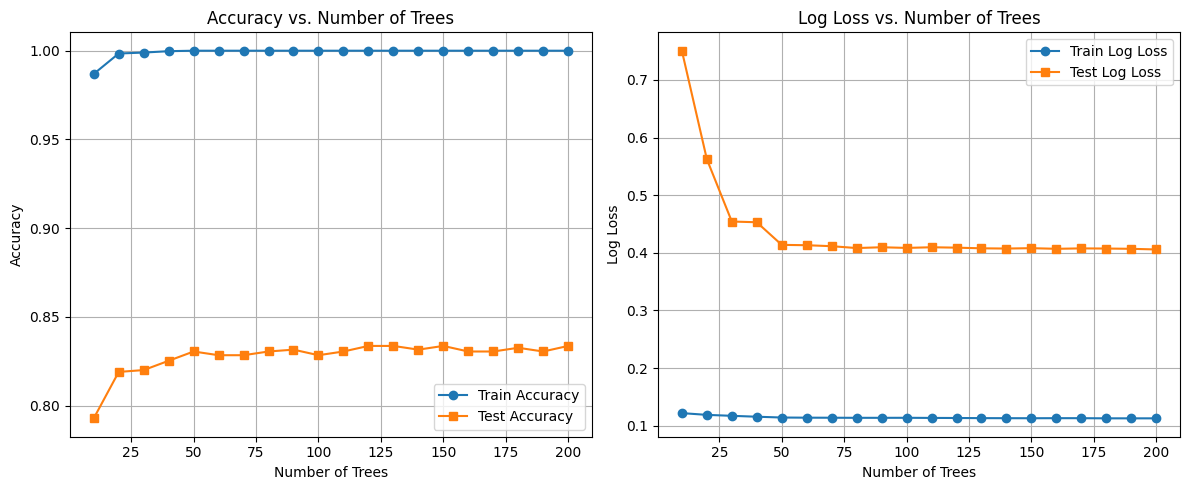

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, log_loss
)
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Convert PyTorch Dataloader to numpy
def dataloader_to_numpy(loader):
    X, y = [], []
    for embeddings, labels in tqdm(loader, desc="Extracting Features"):
        X.append(embeddings.cpu().numpy())
        y.append(labels.cpu().numpy())
    return np.vstack(X), np.hstack(y)

X_train, y_train = dataloader_to_numpy(train_loader)
X_test, y_test = dataloader_to_numpy(test_loader)

tree_steps = list(range(10, 201, 10))  # from 10 to 200 trees

train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list = [], []

rf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

for n in tree_steps:
    print(n)
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)

    # Predictions
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    y_train_prob = rf.predict_proba(X_train)
    y_test_prob = rf.predict_proba(X_test)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_loss = log_loss(y_train, y_train_prob)
    test_loss = log_loss(y_test, y_test_prob)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

# --- Plotting ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(tree_steps, train_acc_list, marker='o', label='Train Accuracy')
plt.plot(tree_steps, test_acc_list, marker='s', label='Test Accuracy')
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Trees")
plt.legend()
plt.grid(True)

# Log Loss plot
plt.subplot(1, 2, 2)
plt.plot(tree_steps, train_loss_list, marker='o', label='Train Log Loss')
plt.plot(tree_steps, test_loss_list, marker='s', label='Test Log Loss')
plt.xlabel("Number of Trees")
plt.ylabel("Log Loss")
plt.title("Log Loss vs. Number of Trees")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# PCA the embedding and color by binding affinity

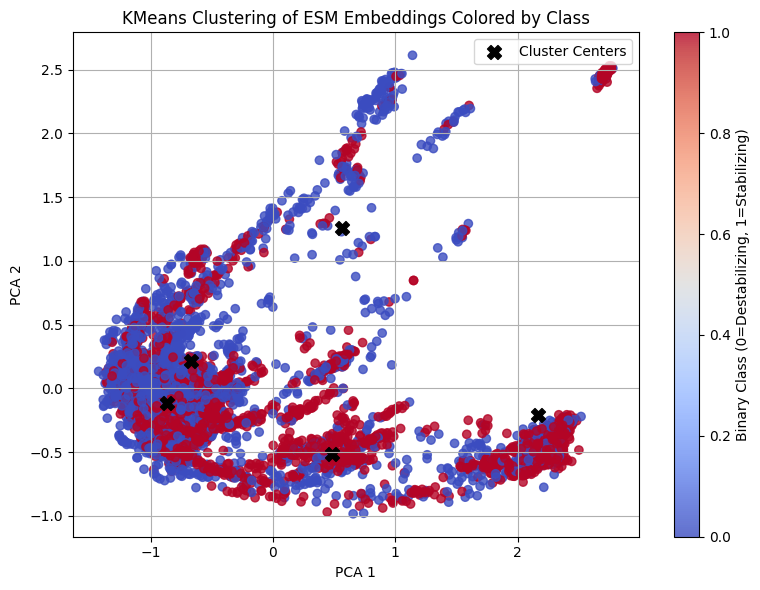

In [82]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Combine train and test sets
X_all = np.vstack([X_train, X_test])
y_all = np.concatenate([y_train, y_test])  # Use actual binary labels (0/1)

# Or.. use model predictions instead of ground truth:
y_all = np.concatenate([rf.predict(X_train), rf.predict(X_test)])

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_all)

# KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_all)

# Plot clusters colored by class (0/1)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1],
                      c=y_all, cmap='coolwarm', alpha=0.8)
plt.colorbar(scatter, label='Binary Class (0=Destabilizing, 1=Stabilizing)')
plt.title("KMeans Clustering of ESM Embeddings Colored by Class")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Overlay cluster centers
centers_2D = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_2D[:, 0], centers_2D[:, 1],
            c='black', s=100, marker='X', label='Cluster Centers')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


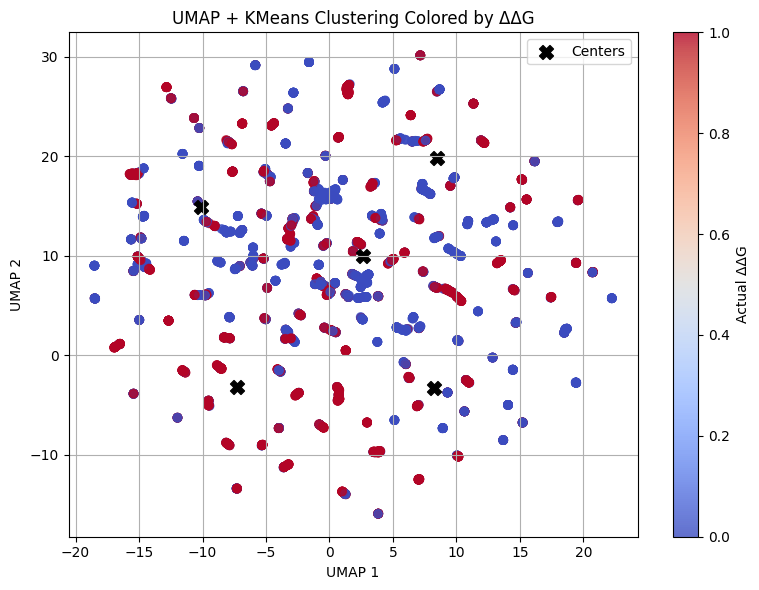

In [83]:
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Reduce ESM embeddings to 2D using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_all)  # X_all = np.vstack([X_train, X_test])

# Step 2: KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_umap)

# Step 3: Visualization (colored by ΔΔG)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1],
                      c=y_all, cmap='coolwarm', alpha=0.8)
plt.colorbar(scatter, label='Actual ΔΔG')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP + KMeans Clustering Colored by ΔΔG")

# Optional: overlay cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=100, label='Centers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
